In [1]:
%matplotlib inline
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from matplotlib import cm as c
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA 

#import matplotlib.pyplot.grid

cm=plt.get_cmap('nipy_spectral') # for the plotting
df=pd.read_csv('ready_data.csv',sep=';' )
dt=df.copy()
#df=df[~np.isnan(df['Nbr_Stages'])]

/home/andreas/.local/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


We check how many different values zone has

In [2]:
zones_distribution=df.groupby('Zone')['API'].count().sort_values(ascending=False)
zones_distribution

Zone
0    208
6    109
5     54
1     53
2     15
9      6
8      5
7      5
3      3
4      2
Name: API, dtype: int64

## Plot Target Varibles grouped by Zone

We filter the zones with >5 records and plot the target varibles grouped by zone.
We see, that the distribution of the target variables highly depends on the zone.

Text(0,0.5,'GasCum360')

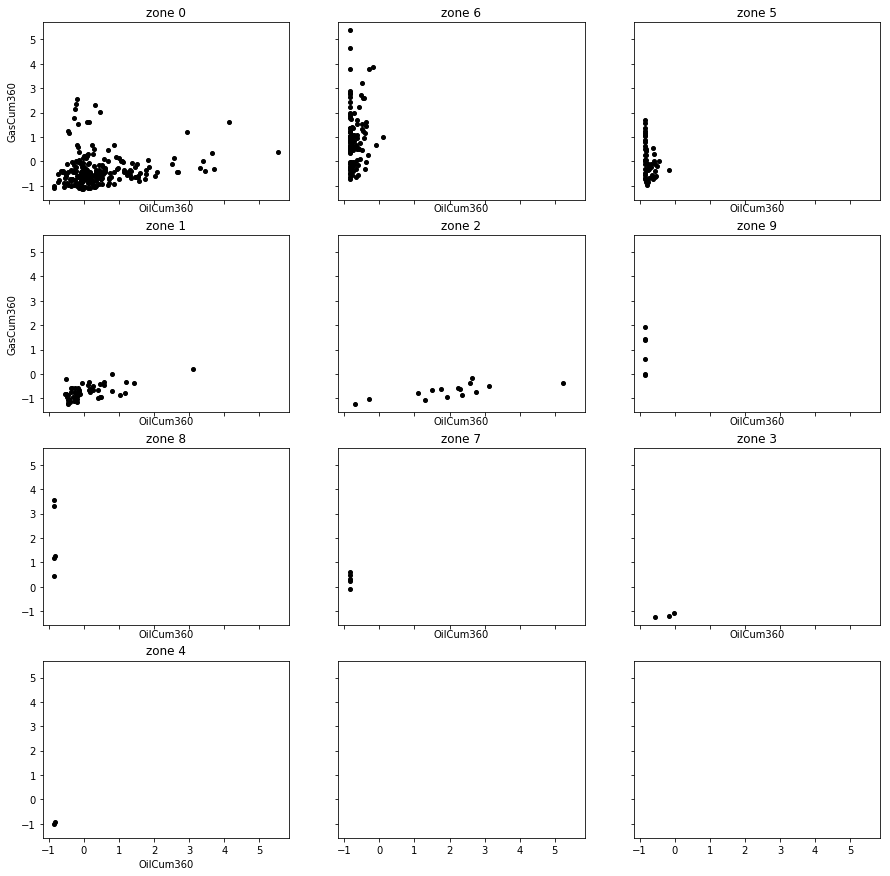

In [3]:
f, axarr = plt.subplots(ncols=3,nrows=4,sharex=True,sharey=True)
f.set_figheight(15)
f.set_figwidth(15)


zones=list()
plt.figure(figsize=(12,18))
count=0

for  i in zones_distribution.index:
    x=[ df['OilCum360'][j] for j in df.index if df['Zone'][j] ==i ] 
    y=[ df['GasCum360'][j] for j in df.index if df['Zone'][j] ==i ]
    axarr[int(count/3),count%3].plot( x,y,'.',ms=8,color='black')
    axarr[int(count/3),count%3].set_title("zone "+str(i))
    axarr[int(count/3),count%3].set_xlabel('OilCum360')
    count=count+1
axarr[0,0].set_ylabel('GasCum360')
axarr[1,0].set_ylabel('GasCum360')

For the gas prediciton, it seems obvious to group the follwowing zones:

group 0:(low gas):          Zones 1,2,4, part of zone 0

group 1:(intermediate)       part of zone 0

group 2:(low oil):         Zones 5,6,7,8,9  part of zone 0


We need to split Zone 0.

## Statistical significance of our grouping by zones
We first leave zone 0 alone in group 1 and make a statistical test.

In [4]:
df['group']=0
# group 1
rows=(df['Zone']==1).values
df.loc[rows,'group']=0

rows=(df['Zone']==2).values
df.loc[rows,'group']=0

rows=(df['Zone']==3).values
df.loc[rows,'group']=0

rows=(df['Zone']==4).values
df.loc[rows,'group']=0

# group 2

rows=(df['Zone']==0).values
df.loc[rows,'group']=1


# group3
rows=(df['Zone']==5).values
df.loc[rows,'group']=2

rows=(df['Zone']==6).values
df.loc[rows,'group']=2

rows=(df['Zone']==7).values
df.loc[rows,'group']=2

rows=(df['Zone']==8).values
df.loc[rows,'group']=2

rows=(df['Zone']==9).values
df.loc[rows,'group']=2


## Explained variance of the grouping

In [5]:
counts=[len(df[df['group']==i]) for i in range (3)]
var_o_exp=[np.var(df[df['group']==i]['OilCum360']) * counts[i] for i in range (3)]
var_o_exp=np.sum(var_o_exp)/len(df)

var_g_exp=[np.var(df[df['group']==i]['GasCum360']) * counts[i] for i in range (3)]
var_g_exp=np.sum(var_g_exp)/len(df)

print('oil variance unexplained: ' + str(np.var(df['OilCum360'])) )
print('oil variance explained:   ' + str(var_o_exp))
print('------------------------------------------------------')
print('gas variance unexplained: ' + str(np.var(df['GasCum360'])) )
print('gas variance explained:   ' + str(var_g_exp) )

oil variance unexplained: 0.971203712653
oil variance explained:   0.641813907819
------------------------------------------------------
gas variance unexplained: 1.02967386891
gas variance explained:   0.720268325234


## Anova Test

In [6]:
d=[df[df['group']==i] for i in range(3)]
oil=[dd['OilCum360'].values for dd in d]
gas=[dd['GasCum360'].values for dd in d]

In [7]:
print('oil')
print(stats.f_oneway(oil[0],oil[2]))
print(stats.f_oneway(oil[0],oil[1]))
print(stats.f_oneway(oil[0],oil[1],oil[2]))
#############################################
print('___________________________________________________________________________________________')
print('gas')

print(stats.f_oneway(gas[0],gas[2]))
print(stats.f_oneway(gas[0],gas[1]))#
print(stats.f_oneway(gas[0],gas[1],gas[2]))#


oil
F_onewayResult(statistic=171.81251541182206, pvalue=3.1453120644549421e-30)
F_onewayResult(statistic=0.01858961803706018, pvalue=0.89164786730514778)
F_onewayResult(statistic=117.27008325562221, pvalue=7.8086056823933892e-42)
___________________________________________________________________________________________
gas
F_onewayResult(statistic=108.87733001756544, pvalue=2.1474169437778448e-21)
F_onewayResult(statistic=25.647669739597486, pvalue=7.4587798073937557e-07)
F_onewayResult(statistic=98.156706678473128, pvalue=3.4321941851595945e-36)


## interpretation:
for oil prediction, splitting group 0 and group 1 is not significant, as they both have
a similar oil distribution.

All other splits are statistically significant. However we will try to improve them by making a better split for zone 0.




##  Cluster Zone 1 

to get an idea how do make the splits, we use hierachical clustering of the target space with 
average, complete and ward link.

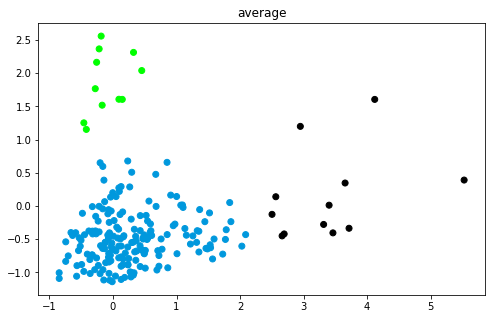

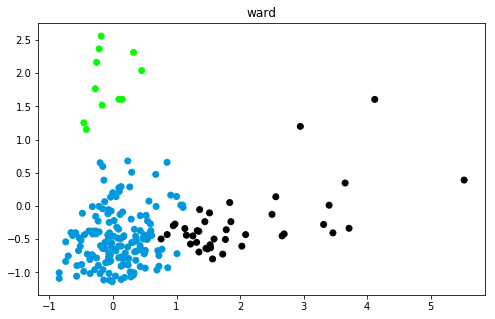

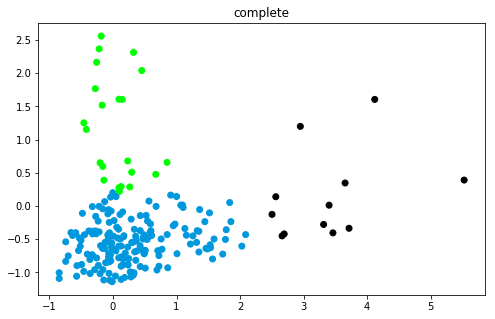

In [8]:

z0=df[df['Zone']==0]
score=[]
labels=[]
for linkage in ('average', 'ward','complete'):#complete is same as average
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=3)
    clustering.fit(z0.loc[:,['GasCum360','OilCum360']])
    labels2=clustering.labels_    
    plt.figure(figsize=(8,5))
    plt.scatter(z0['OilCum360'],z0['GasCum360'],color=cm(labels2*0.3))
    plt.title(linkage)
    labels.append(labels2)
    

## Choice of clustering.



In [9]:
## avergage:
rows=labels[0]==0
filters=np.zeros((3,3,len(z0))).astype(bool)
var_o=np.zeros(3)
var_g=np.zeros(3)
counts=np.zeros((3,3))
for i in range(3):
    for j in range(3):
        filters[i,j,:]=labels[i]==j
        counts[i,j]=np.sum(filters[i,j])
    vo=[np.var(z0.loc[filters[i,k,:],'OilCum360'])* counts[i,k] for k in range(3)]
    var_o[i]=np.sum(vo)
    vg=[np.var(z0.loc[filters[i,k,:],'GasCum360'])* counts[i,k] for k in range(3)]
    var_g[i]=np.sum(vg)

    
    
print('variance oil: '+ str(np.var(z0['OilCum360'])))
print()
print('oil residual sum of squares')
print('avg               ward          comp')
print(var_o/len(z0))
print('-------------------------------------------')
print('variance gas: '+ str(np.var(z0['GasCum360'])))
print()
print('gas residual sum of squares')
print('avg               ward          comp')
print(var_g/len(z0))






variance oil: 0.928699099708

oil residual sum of squares
avg               ward          comp
[ 0.39622764  0.34141825  0.39776744]
-------------------------------------------
variance gas: 0.454778608313

gas residual sum of squares
avg               ward          comp
[ 0.16916854  0.1822974   0.17031555]


We choose the ward clustering, as is has singificanlty lower residual sum of squares for oil and only a slightly higher one for gas.

Note: ward link is built to optimize the variance ( but clustering is in 2D space !!)

## # Paritioning of zone 0

We partition Zone 0 similar to the ward-link clustering, but leaving the two points having high gas and high oil aside for now. ( Better results for svm later according to crossfold)

In [10]:
df['group']=5
###  Zone 0 going to group 3
rows=(df['Zone']==0).values
rows2=(df['GasCum360']>1).values
rows3=(df['OilCum360']<1.2).values
z0_group3=np.logical_and(rows2,rows)
z0_group3=np.logical_and(z0_group3,rows3)
df.loc[z0_group3,'group']=2

##  zone 0 going to group 2
rows4=(df['GasCum360']<1).values
z0_group2=np.logical_and(rows4,rows)
z0_group2=np.logical_and(rows3,z0_group2)
df.loc[z0_group2,'group']=1

##  zone 0 going to group 1
rows5=(df['OilCum360']>1.2).values
rows6=(df['GasCum360']<1).values
z0_group1=np.logical_and(rows,rows5)
z0_group1=np.logical_and(z0_group1,rows6)
df.loc[z0_group1,'group']=0



df2=df[df['Zone']==0].copy()

## Illustration of the partitionning

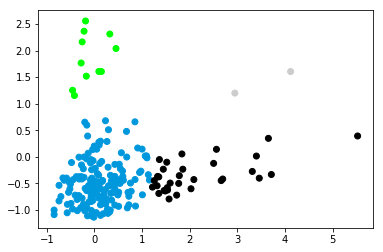

In [11]:
# verification
plt.scatter(df2['OilCum360'],df2['GasCum360'],color=cm(df2['group']*0.3))

## now attribute the other zones to the three groups:

In [12]:
# group 1
rows=(df['Zone']==1).values
df.loc[rows,'group']=1

rows=(df['Zone']==2).values
df.loc[rows,'group']=1

rows=(df['Zone']==3).values
df.loc[rows,'group']=1

rows=(df['Zone']==4).values
df.loc[rows,'group']=1


# group3
rows=(df['Zone']==5).values
df.loc[rows,'group']=3

rows=(df['Zone']==6).values
df.loc[rows,'group']=3

rows=(df['Zone']==7).values
df.loc[rows,'group']=3

rows=(df['Zone']==8).values
df.loc[rows,'group']=3

rows=(df['Zone']==9).values
df.loc[rows,'group']=3


## Training a svm classifier for prediction of the partitions

### group 2 ( green) vs rest

As non of the examples with missing values ( after cleaning) falls into group three, we can exclude them
before.

20 - fold score of class 1 with 11 members:  0.965034965035
20 - fold score of class 0 with 143 members: 0.727272727273


Text(0.5,1,'svm classifier')

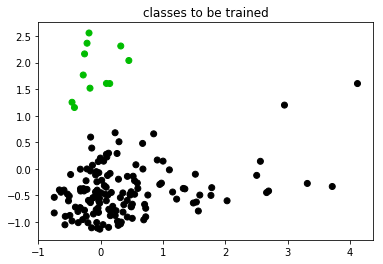

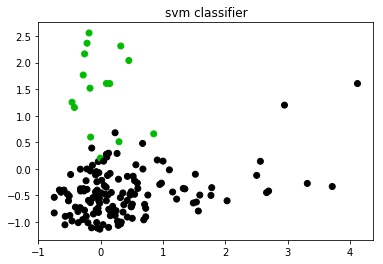

In [24]:
df3=df2[~np.isnan(df2['Nbr_Stages'])]

ind=list(df3.columns)
ind.remove('Zone')
ind.remove('API')


ind.remove('Unnamed: 0')
ind.remove('GasCum360')
ind.remove('OilCum360')

ind.remove('group')

######
z2=df3.loc[:,ind]

x=np.array(z2)
y=df3['group'].values


############# make it binary
for i in range(len(y)):# high gas vs low gas
    if y[i]==2:
        y[i]=1
    else:
        if y[i]==1:
            y[i]=0
        else:
            if y[i]==5:
                y[i]=0
       
plt.scatter(df3['OilCum360'],df3['GasCum360'],color=cm(y*0.5))  
plt.title('classes to be trained')
zzzcount=len(y) -np.sum(y) # 11
######
scaler = StandardScaler()
x=np.array(scaler.fit_transform(x))

pca = PCA(25)
pca.fit(x)
sum=pca.explained_variance_ratio_ 
sum=[np.sum(sum[:i+1]) for i in range(len(sum))]
## first 16 have 95 % of variance 
xx=pca.transform(x)


 
 #################### select attributes
 
u=np.zeros((len(z2),len(xx[0])+1))
u[:,:len(xx[0])]=xx
u[:,len(xx[0])]=y
cor=np.corrcoef(np.transpose(u))
cor=np.abs(cor[:-1,-1])
 

sortet=np.zeros((len(cor),2))
for i in range(len(cor)):
    sortet[i]=[i,cor[i]]

sortet=pd.DataFrame(sortet)
sortet=sortet.sort_values(1,ascending=False)
sortet=sortet[sortet[1]>0.1]
indic=sortet[0].values.astype(int)
X=xx[:,indic]#np.array(df3.loc[:,['DTs_PPLS (us/ft)','S3Tect_PPLS (PSI)']])
##############################################
clf = svm.SVC(class_weight='balanced',kernel='linear')

kf = KFold(n_splits=20)
score0=[]
score1=[]


for train, test in kf.split(df3):
    Xtr=X[train,:]
    Xt=X[test,:]
    ytr=y[train]
    yt=y[test]
    clf.fit(Xtr, ytr)  
    wt=(yt-0.5)*-1 +0.5
    score0.append(clf.score(Xt, yt,sample_weight=wt)*(len(yt)-np.sum(yt)))
    if np.sum(yt)>0:
        score1.append(clf.score(Xt, yt,sample_weight=yt)*np.sum(yt))
 
zscore0=np.sum(score0)/(len(y)-np.sum(y))
zscore1=np.sum(score1)/np.sum(y)

print('20 - fold score of class 1 with 11 members:  ' + str(zscore0))
print('20 - fold score of class 0 with 143 members: ' + str(zscore1))
######
#make it ready for deployment
clf.fit(X, y) 
zl=clf.predict(X)
plt.figure()
plt.scatter(df3['OilCum360'],df3['GasCum360'],color=cm((zl/2)))
plt.title('svm classifier')

As the classes are artififical anyway, we the above given class accuracies are sufficient. Hence we use the decision border of the svm trained on the complete data set to make our split.

## group 0 (green) vs rest

This time we have to include the examples with the missing values. Therefore we will use only 
a part of the features to train our svm classifier.

208
20 - fold score of class 1 with 28 members:  0.863636363636
20 - fold score of class 0 with 176 members: 0.875


Text(0.5,1,'svm classifier')

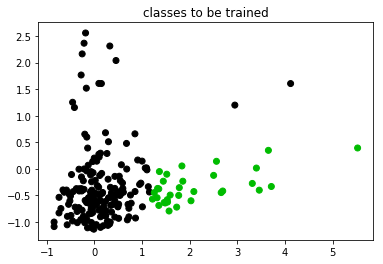

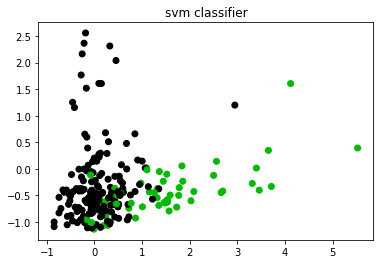

In [25]:
print(len(df2))

ind=list(df2.columns)
ind.remove('Zone')
ind.remove('API')

ind.remove('Unnamed: 0')
ind.remove('GasCum360')
ind.remove('OilCum360')



for n in ind.copy():
    if np.sum(np.isnan(df2[n]))> 0:
        ind.remove(n)
        
######
df3=df2.loc[:,ind]
ind.remove('group')
z2=df3.loc[:,ind]
x=np.array(z2)
y=df3['group'].values


############# make it binary
for i in range(len(y)):# high gas vs low gas
    if y[i]>=1:
        y[i]=0
    else:
        if y[i]==0:
            y[i]=1
        
zzzcount=len(y) -np.sum(y) # 11
######

#plt.scatter(df5['OilCum360'],df5['GasCum360'])

plt.scatter(df2['OilCum360'],df2['GasCum360'],color=cm(y*0.5))
plt.title('classes to be trained')
scaler2 = StandardScaler()
x=np.array(scaler2.fit_transform(x))

pca2 = PCA(15)
pca2.fit(x)
sum=pca2.explained_variance_ratio_ 
sum=[np.sum(sum[:i+1]) for i in range(len(sum))]
## first 16 have 95 % of variance 
xx=pca2.transform(x)


 
 #################### select attributes
 
u=np.zeros((len(z2),len(xx[0])+1))
u[:,:len(xx[0])]=xx
u[:,len(xx[0])]=y
cor=np.corrcoef(np.transpose(u))
cor=np.abs(cor[:-1,-1])
 

sortet=np.zeros((len(cor),2))
for i in range(len(cor)):
    sortet[i]=[i,cor[i]]

sortet=pd.DataFrame(sortet)
sortet=sortet.sort_values(1,ascending=False)
sortet=sortet[sortet[1]>0.04]
indic2=sortet[0].values.astype(int)
X=xx[:,indic2]#np.array(df3.loc[:,['DTs_PPLS (us/ft)','S3Tect_PPLS (PSI)']])
##############################################
clf2 = svm.SVC(class_weight='balanced',kernel='linear')

kf2 = KFold(n_splits=20)
score0=[]
score1=[]


for train, test in kf2.split(df2):
    Xtr=X[train,:]
    Xt=X[test,:]
    ytr=y[train]
    yt=y[test]
    clf2.fit(Xtr, ytr)  
    wt=(yt-0.5)*-1 +0.5
    score0.append(clf2.score(Xt, yt,sample_weight=wt)*(len(yt)-np.sum(yt)))
   
    
    if np.sum(yt)>0:
        score1.append(clf2.score(Xt, yt,sample_weight=yt)*np.sum(yt))
 
zscore0=np.sum(score0)/(len(y)-np.sum(y))
zscore1=np.sum(score1)/np.sum(y)

print('20 - fold score of class 1 with 28 members:  ' + str(zscore0))
print('20 - fold score of class 0 with 176 members: ' + str(zscore1))
clf2.fit(X, y) 
zl2=clf2.predict(X)
plt.figure()
plt.scatter(df2['OilCum360'],df2['GasCum360'],color=cm((zl2/2)))
plt.title('svm classifier')

The classification is not perfect, but we consider it sufficient, we will show its significance with an anove later.

## For deployment ( zone 1, group 2)

(154, 42)


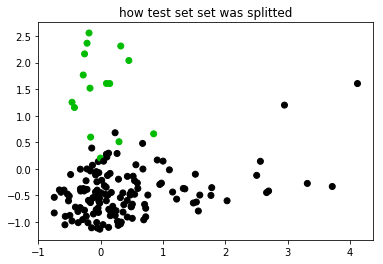

In [27]:
#dft=df.loc[10:220,:] # ################################################## change for test set
#dt2=dt.loc[200:400,:]
dt['group']=5
dt2=dt.loc[dt['Zone']==0,:]
dt3=dt2.loc[~np.isnan(dt2['Nbr_Stages']),:]
### prepare data frame
indt=list(dt3.columns)
indt.remove('Zone')
indt.remove('API')
indt.remove('Unnamed: 0')################################################## change for test set
indt.remove('GasCum360')################################################## change for test set
indt.remove('OilCum360')################################################## change for test set
indt.remove('group')


zt2=dt3.loc[:,indt]
xt=np.array(zt2)
print(np.shape(xt))
# pca + normalization + feature selection
xt=np.array(scaler.transform(xt))
xxt=pca.transform(xt)
Xt=xxt[:,indic]
# apply the trained model
predt=clf.predict(Xt)
plt.figure()
plt.scatter(dt3['OilCum360'],dt3['GasCum360'],color=cm((predt/2)))
plt.title('how test set set was splitted')
###write from binary to the three groups
group3=predt==1
rows=dt3.loc[group3,:].index
dt.loc[rows,'group']=2


Text(0.5,1,'verification of writing on dummy test data frame')

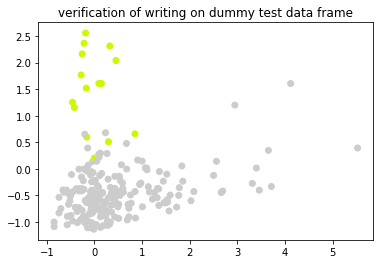

In [28]:
# verify whether seeting the group was effective on test df
plt.scatter(dt[dt['Zone']==0]['OilCum360'],dt[dt['Zone']==0]['GasCum360'],color=cm(dt[dt['Zone']==0]['group']/3))
plt.title('verification of writing on dummy test data frame')

## For deployment ( zone 1 group 3)

## not that the groups overlap. This is ok. The groups gives us just a
## preliminary to seperate high oil form not high oil. gas respectively

In [ ]:
df.to_csv('partitionned_data2.csv')

In [ ]:
v

## predict split of zone 0 with a svm